In [4]:
!pip install torch torchvision scikit-learn tqdm


from google.colab import files
import zipfile, os, numpy as np

uploaded = files.upload()
for fname in uploaded:
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall("data")
        print("✅ Extracted:", fname)


npz_file = None
for root, dirs, files in os.walk("data"):
    for file in files:
        if file.endswith(".npz"):
            npz_file = os.path.join(root, file)
            break
if not npz_file:
    raise FileNotFoundError("❌ .npz file not found!")

print("✅ Found:", npz_file)


import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

data = np.load(npz_file)

def preprocess_images(images_np):
    images = torch.tensor(images_np, dtype=torch.float32).unsqueeze(1) / 255.0
    images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
    images = images.repeat(1, 3, 1, 1)
    return images

x_train = preprocess_images(data['train_images'])
y_train = torch.tensor(data['train_labels'], dtype=torch.float32).view(-1, 1)
x_val = preprocess_images(data['val_images'])
y_val = torch.tensor(data['val_labels'], dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=32, shuffle=False)


import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_resnet_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classifier
    return model.to(device)

model = get_resnet_model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


def train_model(epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, all_preds, all_labels = 0, [], []
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device).view(-1, 1)
            out = model(x)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(out) > 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

        print(f"Epoch {epoch+1} | Loss={total_loss:.4f} | Acc={accuracy_score(all_labels, all_preds):.4f} | Prec={precision_score(all_labels, all_preds):.4f} | Rec={recall_score(all_labels, all_preds):.4f}")

train_model(10)
torch.save(model.state_dict(), "resnet18_pneumonia.pth")


model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device).view(-1, 1)
        out = model(x)
        preds = (torch.sigmoid(out) > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))



Saving archive.zip to archive (3).zip
✅ Extracted: archive (3).zip
✅ Found: data/pneumoniamnist.npz


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 122/122 [00:12<00:00,  9.55it/s]


Epoch 1 | Loss=26.2702 | Acc=0.9129 | Prec=0.9829 | Rec=0.9193


100%|██████████| 122/122 [00:12<00:00,  9.45it/s]


Epoch 2 | Loss=6.7267 | Acc=0.9820 | Prec=0.9880 | Rec=0.9920


100%|██████████| 122/122 [00:12<00:00,  9.40it/s]


Epoch 3 | Loss=3.6316 | Acc=0.9910 | Prec=0.9946 | Rec=0.9954


100%|██████████| 122/122 [00:12<00:00,  9.59it/s]


Epoch 4 | Loss=1.9612 | Acc=0.9948 | Prec=0.9963 | Rec=0.9980


100%|██████████| 122/122 [00:12<00:00,  9.65it/s]


Epoch 5 | Loss=1.8835 | Acc=0.9954 | Prec=0.9974 | Rec=0.9974


100%|██████████| 122/122 [00:12<00:00,  9.66it/s]


Epoch 6 | Loss=1.7549 | Acc=0.9946 | Prec=0.9966 | Rec=0.9974


100%|██████████| 122/122 [00:12<00:00,  9.67it/s]


Epoch 7 | Loss=1.3491 | Acc=0.9961 | Prec=0.9980 | Rec=0.9977


100%|██████████| 122/122 [00:12<00:00,  9.64it/s]


Epoch 8 | Loss=1.1817 | Acc=0.9974 | Prec=0.9980 | Rec=0.9991


100%|██████████| 122/122 [00:12<00:00,  9.60it/s]


Epoch 9 | Loss=0.5272 | Acc=0.9992 | Prec=0.9994 | Rec=0.9997


100%|██████████| 122/122 [00:12<00:00,  9.54it/s]


Epoch 10 | Loss=1.2852 | Acc=0.9967 | Prec=0.9983 | Rec=0.9980

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.79      0.88       135
   Pneumonia       0.93      1.00      0.96       389

    accuracy                           0.94       524
   macro avg       0.96      0.89      0.92       524
weighted avg       0.95      0.94      0.94       524




=== MODEL EVALUATION RESULTS ===
Test F1-Score: 0.9699
Test AUC-ROC: 0.9963
Test AUC-PR: 0.9987

=== CLINICAL INTERPRETATION ===
Sensitivity (True Positive Rate): 0.9949 - Ability to correctly identify pneumonia cases
Specificity (True Negative Rate): 0.8370 - Ability to correctly identify normal cases
Positive Predictive Value: 0.9462 - Probability that a positive prediction is correct
Negative Predictive Value (NPV): 0.9826 - Probability that a negative prediction is correct

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Normal       0.98      0.84      0.90       135
   Pneumonia       0.95      0.99      0.97       389

    accuracy                           0.95       524
   macro avg       0.96      0.92      0.94       524
weighted avg       0.96      0.95      0.95       524



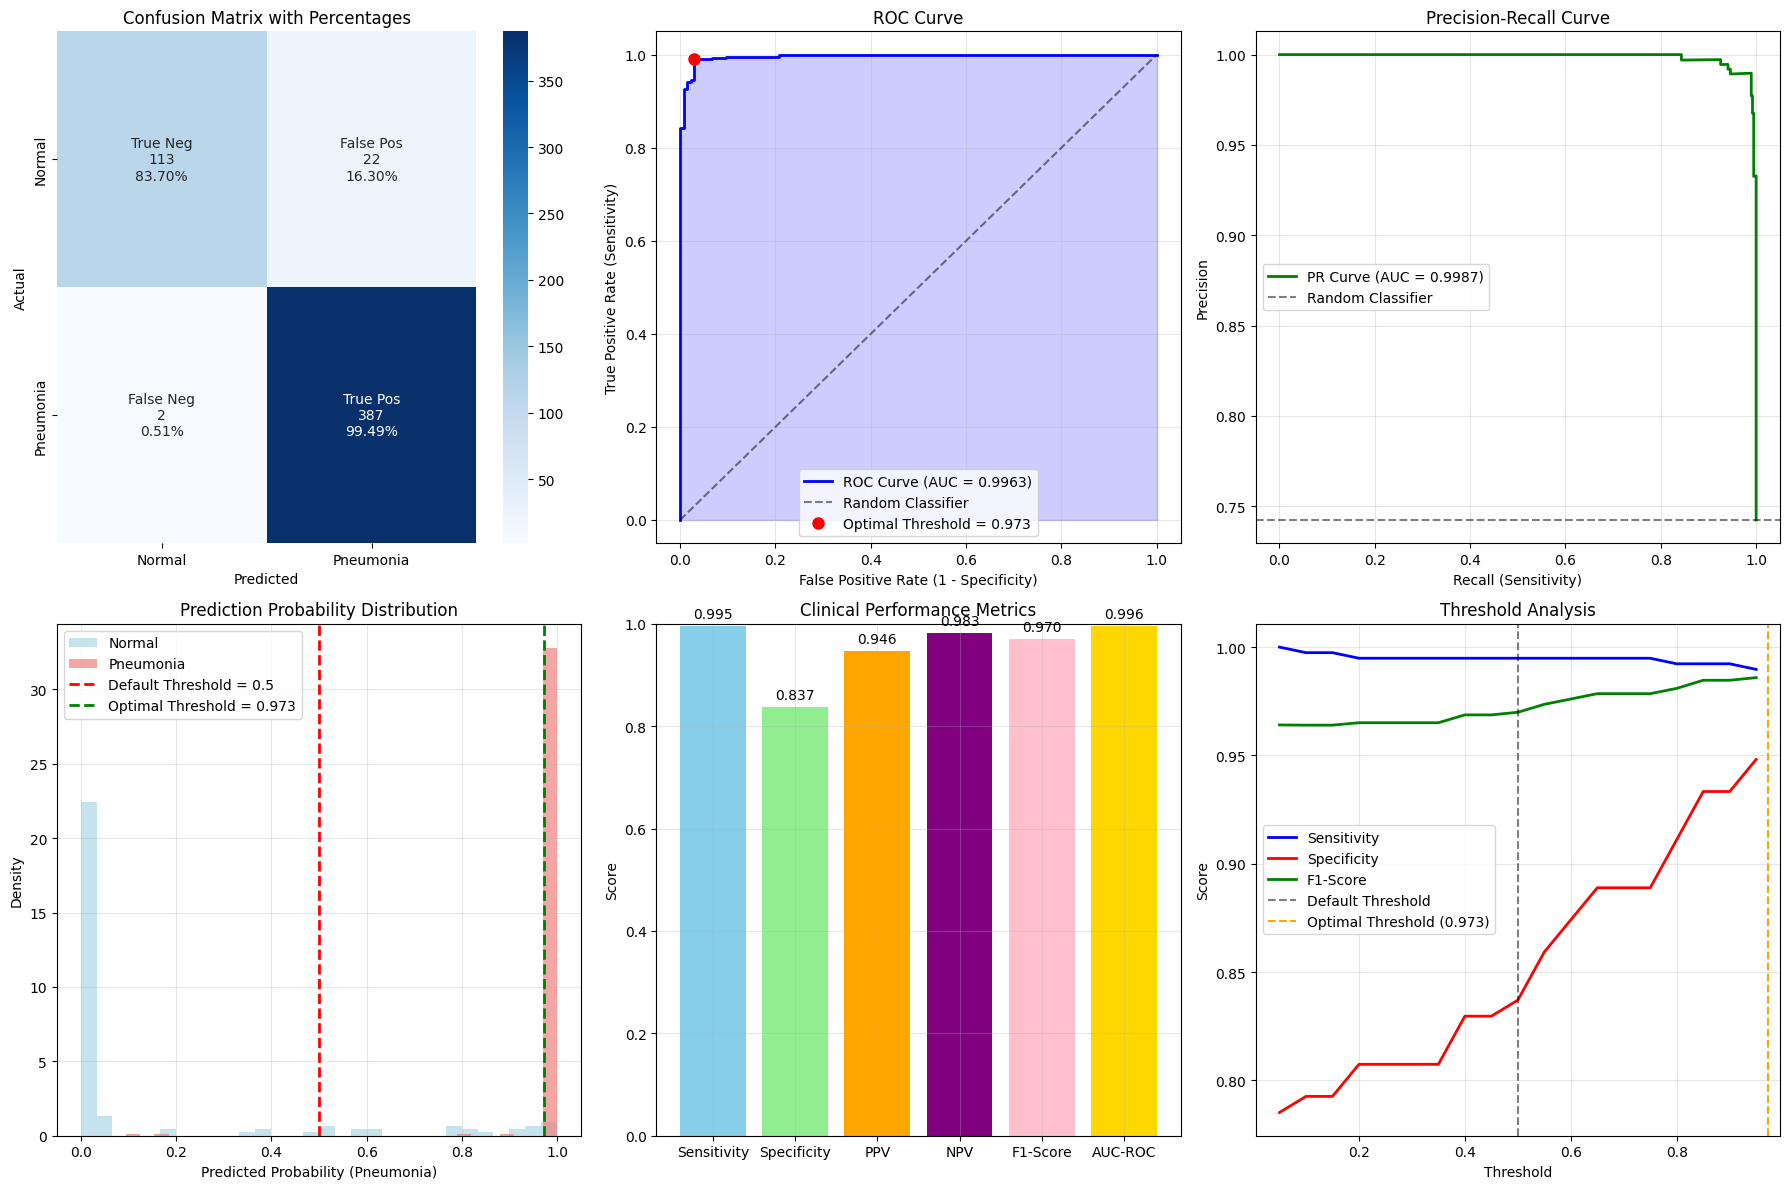

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, f1_score, precision_recall_curve, average_precision_score, roc_auc_score
import torch
import numpy as np
import seaborn as sns


def evaluate_model(model, x_test, y_test, class_names=['Normal', 'Pneumonia']):
    """Comprehensive model evaluation with multiple metrics including sensitivity, specificity, and enhanced visualizations"""

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for x, y in zip(x_test, y_test):
            x = x.unsqueeze(0).to(device) # Add batch dimension and move to device
            y = y.unsqueeze(0).to(device) # Add batch dimension and move to device

            out = model(x)
            probs = torch.sigmoid(out).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy().flatten())


    y_true = np.array(all_labels).astype(int).flatten()
    y_pred = np.array(all_preds).flatten()
    y_probs = np.array(all_probs).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate additional metrics
    f1 = f1_score(y_true, y_pred)

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_true, y_probs)

    # Calculate Sensitivity and Specificity from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    # Calculate additional clinical metrics
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

    # Calculate Precision-Recall AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
    auc_pr = average_precision_score(y_true, y_probs)

    print("\n=== MODEL EVALUATION RESULTS ===")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC-ROC: {auc_roc:.4f}")
    print(f"Test AUC-PR: {auc_pr:.4f}")


    print("\n=== CLINICAL INTERPRETATION ===")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.4f} - Ability to correctly identify pneumonia cases")
    print(f"Specificity (True Negative Rate): {specificity:.4f} - Ability to correctly identify normal cases")
    print(f"Positive Predictive Value: {ppv:.4f} - Probability that a positive prediction is correct")
    print(f"Negative Predictive Value (NPV): {npv:.4f} - Probability that a negative prediction is correct")


    # Classification report
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Enhanced visualizations
    create_comprehensive_visualizations(y_true, y_pred, y_probs,
                                       cm, class_names, auc_roc, auc_pr,
                                       sensitivity, specificity, ppv, npv, f1, precision_vals, recall_vals)


    return {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'ppv': ppv,
        'npv': npv,
        'confusion_matrix': cm
    }

def create_comprehensive_visualizations(y_true, y_pred, y_probs,
                                       cm, class_names, auc_roc, auc_pr,
                                       sensitivity, specificity, ppv, npv, f1, precision_vals, recall_vals):
    """Create comprehensive visualization plots"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Enhanced Confusion Matrix with percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create combined labels for confusion matrix
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm_percent.flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix with Percentages')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')

    # 2. ROC Curve with confidence intervals
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)

    axes[0,1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc_roc:.4f})')
    axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    axes[0,1].fill_between(fpr, tpr, alpha=0.2, color='blue')
    axes[0,1].set_xlabel('False Positive Rate (1 - Specificity)')
    axes[0,1].set_ylabel('True Positive Rate (Sensitivity)')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Add optimal threshold point (using Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    axes[0,1].plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8,
                   label=f'Optimal Threshold = {optimal_threshold:.3f}')
    axes[0,1].legend()


    # 3. Precision-Recall Curve
    axes[0,2].plot(recall_vals, precision_vals, 'g-', linewidth=2,
                   label=f'PR Curve (AUC = {auc_pr:.4f})')
    axes[0,2].axhline(y=np.mean(y_true), color='k', linestyle='--',
                      alpha=0.5, label='Random Classifier')
    axes[0,2].set_xlabel('Recall (Sensitivity)')
    axes[0,2].set_ylabel('Precision')
    axes[0,2].set_title('Precision-Recall Curve')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. Prediction Distribution with threshold
    axes[1,0].hist(y_probs[y_true == 0], bins=30, alpha=0.7,
                   label='Normal', color='lightblue', density=True)
    axes[1,0].hist(y_probs[y_true == 1], bins=30, alpha=0.7,
                   label='Pneumonia', color='lightcoral', density=True)
    axes[1,0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Default Threshold = 0.5')
    axes[1,0].axvline(x=optimal_threshold, color='green', linestyle='--',
                      linewidth=2, label=f'Optimal Threshold = {optimal_threshold:.3f}')
    axes[1,0].set_xlabel('Predicted Probability (Pneumonia)')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('Prediction Probability Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 5. Clinical Metrics Bar Chart
    metrics = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-Score', 'AUC-ROC']
    values = [sensitivity, specificity, ppv, npv, f1, auc_roc]

    bars = axes[1,1].bar(metrics, values, color=['skyblue', 'lightgreen', 'orange', 'purple', 'pink', 'gold'])
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Clinical Performance Metrics')
    axes[1,1].set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom')

    axes[1,1].grid(True, alpha=0.3)

    # 6. Threshold Analysis
    thresholds_range = np.arange(0.05, 1.0, 0.05) # Start from a lower threshold
    sensitivity_scores = []
    specificity_scores = []
    f1_scores = []

    for thresh in thresholds_range:
        pred_thresh = (y_probs >= thresh).astype(int)
        cm_thresh = confusion_matrix(y_true, pred_thresh)

        if cm_thresh.shape == (2, 2):
            tn, fp, fn, tp = cm_thresh.ravel()
            sens = tp / (tp + fn) if (tp + fn) > 0 else 0
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1 = f1_score(y_true, pred_thresh)

            sensitivity_scores.append(sens)
            specificity_scores.append(spec)
            f1_scores.append(f1)
        else:
            sensitivity_scores.append(0)
            specificity_scores.append(0)
            f1_scores.append(0)

    axes[1,2].plot(thresholds_range, sensitivity_scores, 'b-', label='Sensitivity', linewidth=2)
    axes[1,2].plot(thresholds_range, specificity_scores, 'r-', label='Specificity', linewidth=2)
    axes[1,2].plot(thresholds_range, f1_scores, 'g-', label='F1-Score', linewidth=2)
    axes[1,2].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default Threshold')
    axes[1,2].axvline(x=optimal_threshold, color='orange', linestyle='--',
                      label=f'Optimal Threshold ({optimal_threshold:.3f})')
    axes[1,2].set_xlabel('Threshold')
    axes[1,2].set_ylabel('Score')
    axes[1,2].set_title('Threshold Analysis')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Call the evaluation function with the existing data and model
results = evaluate_model(model, x_val, y_val)